# Test simulated read alignments look the same as real ones

What's this notebook about?

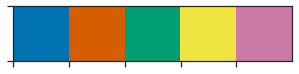

In [1]:
import re
import sys
import os
from glob import glob
from collections import defaultdict, Counter
import random

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import pysam

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
CS_SPLITTER = '([-+*~=:])'

def parse_cs_tag(cs_tag):
    '''
    generalisable function for parsing minimap2 cs tag (long and short form)
    '''
    cs_tag = re.split(CS_SPLITTER, cs_tag)[1:]
    cs_ops = cs_tag[::2]
    cs_info = cs_tag[1::2]
    cs_parsed = []
    for op, info in zip(cs_ops, cs_info):
        if op == '=':
            # long form match
            cs_parsed.append(('=', len(info), info))
        elif op == ':':
            # short form match
            cs_parsed.append(('=', int(info), None))
        elif op == '*':
            # mismatch
            ref = info[0]
            alt = info[1]
            cs_parsed.append((op, 1, (ref, alt)))
        elif op == '+' or op == '-':
            cs_parsed.append((op, len(info), info))
        elif op == '~':
            donor_motif, intron_length, acceptor_motif = re.match(
                '^([acgtn]{2})([0-9]+)([acgtn]{2})', info).groups()
            motif = (donor_motif + acceptor_motif).upper()
            intron_length = int(intron_length)
            cs_parsed.append((op, intron_length, motif))
    return cs_parsed


def get_alignment_metrics(aln):
    identity = 1 - aln.get_tag('de')
    cs_tag = parse_cs_tag(aln.get_tag('cs'))
    mm = Counter()
    ins = []
    del_ = []
    for i, (op, ln, info) in enumerate(cs_tag):
        if op == '+':
            ins.append(ln)
        elif op == '-':
            del_.append(ln)
        elif op == '=':
            pass
        elif op == '*':
            mm[info] += 1
        elif op == '~':
            continue
    return identity, ins, del_, mm

In [3]:
def get_identity_ins_del_mismatches(bam_fn):
    identity = []
    ins = []
    del_ = []
    mm = Counter()

    with pysam.AlignmentFile(bam_fn) as bam:
        for aln in bam.fetch():
            ident, i, d, m = get_alignment_metrics(aln)
            identity.append(ident)
            ins.append(i)
            del_.append(d)
            mm += m

    ins = np.concatenate(ins)
    del_ = np.concatenate(del_)
    return identity, ins, del_, mm

arath_real_identity, arath_real_ins, arath_real_del, arath_real_mm = get_identity_ins_del_mismatches(
    '../arabidopsis_drs/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/aligned_data/201901_col0_2916.real.firstpass.bam'
)


arath_sim_identity, arath_sim_ins, arath_sim_del, arath_sim_mm = get_identity_ins_del_mismatches(
    '../arabidopsis_drs/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/aligned_data/201901_col0_2916.sim_nofrag.firstpass.bam'
)

In [4]:
np.mean(arath_real_identity), np.mean(arath_sim_identity)

(0.8940417967950324, 0.8944037790820834)

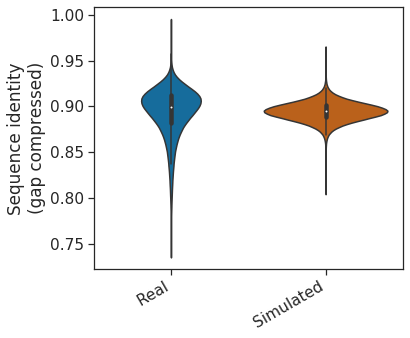

In [5]:
x = np.repeat([0, 1], [len(arath_real_identity), len(arath_sim_identity)])
y = np.concatenate([arath_real_identity, arath_sim_identity])

fig, ax = plt.subplots(figsize=(6, 5))
sns.violinplot(x=x, y=y)
ax.set_xticklabels(['Real', 'Simulated'], rotation=30, ha='right')
ax.set_ylabel('Sequence identity\n(gap compressed)')
plt.tight_layout()
plt.savefig('figures/simulated_data_identity.svg')
plt.show()

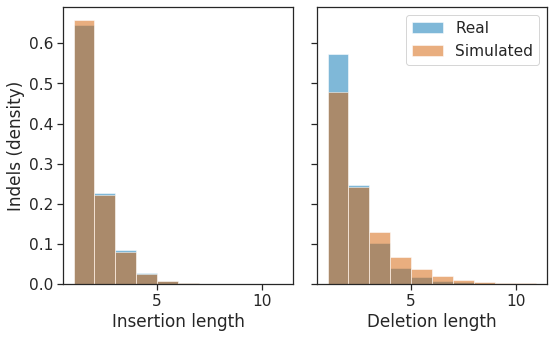

In [6]:
fig, axes = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)

axes[0].hist(arath_real_ins, bins=10, range=(1, 11), alpha=0.5, density=True)
axes[0].hist(arath_sim_ins, bins=10, range=(1, 11), alpha=0.5, density=True)

axes[1].hist(arath_real_del, bins=10, range=(1, 11), alpha=0.5, density=True, label='Real')
axes[1].hist(arath_sim_del, bins=10, range=(1, 11), alpha=0.5, density=True, label='Simulated')

axes[0].set_ylabel('Indels (density)')
axes[0].set_xlabel('Insertion length')
axes[1].set_xlabel('Deletion length')

axes[1].legend()
plt.tight_layout()
plt.savefig('figures/simulated_data_indels.svg')
plt.show()

In [16]:
def mm_counter_to_confusion_matrix(mm):
    mm_df = pd.Series(mm).reset_index()
    mm_df.columns = ['ref', 'read', 'freq']
    mm_df = mm_df.query('ref != "n" & read != "n"').copy()
    mm_df['ref'] = mm_df.ref.str.upper()
    mm_df['read'] = mm_df['read'].str.upper()
    mm_df['prop'] = mm_df['freq'] / mm_df['freq'].sum()
    mm_df = mm_df.pivot(index='read', columns='ref', values='prop')
    return mm_df

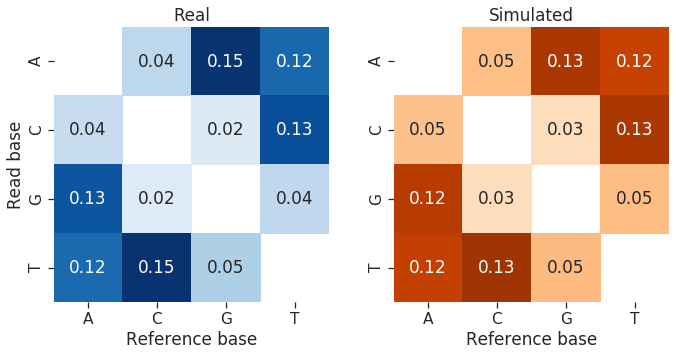

In [17]:
mm_df = mm_counter_to_confusion_matrix(arath_real_mm)
sim_mm_df = mm_counter_to_confusion_matrix(arath_sim_mm)

fig, axes = plt.subplots(figsize=(10, 5), ncols=2)

sns.heatmap(mm_df, cmap='Blues', square=True, annot=True, fmt='.2f', ax=axes[0], vmin=0, vmax=0.15, cbar=False)
sns.heatmap(sim_mm_df, cmap='Oranges', square=True, annot=True, fmt='.2f', ax=axes[1], vmin=0, vmax=0.15, cbar=False)
axes[0].set_xlabel('Reference base')
axes[0].set_ylabel('Read base')
axes[1].set_xlabel('Reference base')
axes[1].set_ylabel('')
axes[0].set_title('Real')
axes[1].set_title('Simulated')
plt.tight_layout()
plt.savefig('figures/simulated_data_mismatches.svg')
plt.show()